In [28]:
import torch
from torchvision import transforms, datasets
from torchvision.transforms import CenterCrop
from torch.utils.data import DataLoader, TensorDataset, Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

trainset = datasets.ImageFolder(root="../datasets/images/flowers/", transform=data_transform)
print("Training set consists of %d images" % (trainset.__len__()))

Training set consists of 4324 images


In [30]:
from utils.data import sampler

batch_size = 64

trainloader = DataLoader(
    dataset = trainset, 
    sampler = sampler.StratifiedSampler(data_source=trainset, n_splits=1, val_size=0.4, random_state=69, sample_train=True),
    batch_size = batch_size,
)

valloader = DataLoader(
    dataset = trainset, 
    sampler = sampler.StratifiedSampler(data_source=trainset, n_splits=1, val_size=0.4, random_state=69, sample_train=False),
    batch_size = batch_size,
)

classes_name = trainset.classes

In [31]:
import torch.nn as nn

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

LeNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Linear(in_features=120, out_features=84),
    nn.Linear(in_features=84, out_features=10),
    )

LeNet.to(device)
print(LeNet)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Linear(in_features=120, out_features=84, bias=True)
  (9): Linear(in_features=84, out_features=10, bias=True)
)


In [32]:
# define loss function and optimizer

import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(LeNet.parameters(), lr=0.001, momentum=0.9)

In [33]:
# training

from tqdm import tqdm

loss_history = []
accuracy_history = []

for epoch in tqdm(range(100)):
    classes_correct = list(0. for i in range(5))
    classes_total = list(0. for i in range(5))
    
    for i, train_data in enumerate(trainloader):
        
        # take input
        pixels, label = train_data
        
        # make sure gradient is 0
        optimizer.zero_grad()
        
        # forward pass
        pixels, label = pixels.to(device), label.to(device)
        label = label.to(device)
        prediction = LeNet(pixels)
        
        # calculate loss & record it 
        loss_score = loss_fn(prediction, label)
        
        if i == (trainloader.__len__()-1): 
            loss_history.append(loss_score)
        
        # calculate accuracy & record it
        _, prediction_label = torch.max(prediction, dim=1)
        
        for i,j in zip(label,prediction_label):
            if i == j:
                classes_correct[i] += 1
            classes_total[i] += 1
        
        # backprop
        loss_score.backward()
        
        # update weight 
        optimizer.step()
    
    accuracy_per_epoch = sum(classes_correct)/sum(classes_total)
    accuracy_history.append(accuracy_per_epoch)
    

100%|██████████| 100/100 [13:40<00:00,  8.21s/it]


In [44]:
label

tensor([0, 0], device='cuda:0')

In [88]:
torch.topk(prediction, 5)

(tensor([[5.2989, 5.2043, 5.1271, 4.6031, 4.1909],
         [4.0662, 3.6406, 3.5373, 3.3441, 2.4749]], device='cuda:0'),
 tensor([[3, 1, 0, 4, 2],
         [0, 1, 4, 2, 3]], device='cuda:0'))

In [71]:
torch.topk(prediction,5)[1] 

tensor([[3, 1, 0, 4, 2],
        [0, 1, 4, 2, 3]], device='cuda:0')

In [82]:
torch.topk(prediction,5)[1].view(prediction.size(0),1,-1)

tensor([[[3, 1, 0, 4, 2]],

        [[0, 1, 4, 2, 3]]], device='cuda:0')

In [85]:
label.view(label.size(0),1,-1)

tensor([[[0]],

        [[0]]], device='cuda:0')

In [87]:
torch.sum(torch.topk(prediction,5)[1].view(prediction.size(0),1,-1) == label.view(label.size(0),1,-1))

tensor(2, device='cuda:0')

In [35]:
for i,(j,k) in enumerate(zip(classes_correct, classes_total)):
    print("Accuracy of %s is %d%s" % (classes_name[i], j/k*100, "%"))

Accuracy of daisy is 44%
Accuracy of dandelion is 76%
Accuracy of rose is 27%
Accuracy of sunflower is 53%
Accuracy of tulip is 43%


In [36]:
print(classes_correct)
print(classes_total)
print(sum(classes_correct)/sum(classes_total))

[206.0, 483.0, 128.0, 235.0, 258.0]
[462.0, 631.0, 470.0, 441.0, 590.0]
0.505011565150347


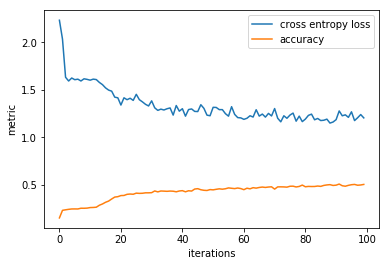

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_history, label="cross entropy loss");
plt.plot(accuracy_history, label="accuracy")
plt.xlabel('iterations');
plt.ylabel('metric');
plt.legend();

In [40]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

# validation
with torch.no_grad():
    for i, val_data in tqdm(enumerate(valloader)):
        
        # take pixels
        pixels, label = val_data
        pixels, label = pixels.to(device), label.to(device)
        
        # forward pass
        prediction = LeNet(pixels)
        
        # count accuracy
        _,prediction_label = torch.max(prediction, dim=1)
        for i,j in zip(label, prediction_label):
            if i==j:
                class_correct[i] += 1
            class_total[i] += 1


28it [00:05,  4.99it/s]


In [41]:
for i,(j,k) in enumerate(zip(class_correct, class_total)):
    print("Accuracy of %s is: %d%s"  % (classes_name[i], j/k*100, "%"))

Accuracy of daisy is: 35%
Accuracy of dandelion is: 79%
Accuracy of rose is: 27%
Accuracy of sunflower is: 46%
Accuracy of tulip is: 45%
